In [140]:
import numpy as np
from scipy.signal import hanning

def general_cosine(x, a):
    w = np.zeros_like(x)
    for k in range(len(a)):
        w += a[k] * np.cos(k * x)

    return w

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def radial_window_mask(window_size: tuple, theta_shift=0., r: float = np.pi, window_type: str = 'blackman'):
    if window_type.lower() == 'hanning':
        a = [0.5] * 2
    elif window_type.lower() == 'blackman':
        a = [0.42, 0.50, 0.08]
    m, n = window_size

    xx, yy = np.meshgrid(
        np.linspace(-r, r, n, dtype=np.float32),
        np.linspace(-r, r, m, dtype=np.float32),
        indexing='xy'
    )

    rho, phi = cart2pol(xx, yy)

    return general_cosine(rho + theta_shift, a)

def square_window_mask(window_size: tuple, theta_shift=0., r: float = np.pi, window_type: str = 'blackman'):
    if window_type.lower() == 'hanning':
        a = [0.5] * 2
    elif window_type.lower() == 'blackman':
        a = [0.42, 0.50, 0.08]
    m, n = window_size

    xx, yy = np.meshgrid(
        np.arange(n, dtype=np.float32),
        np.arange(m, dtype=np.float32),
        indexing='xy'
    )

    rho, phi = cart2pol(xx - n / 2, yy - m / 2)

    R = np.sqrt((m / 2) ** 2 + (n / 2) ** 2)

    bins = m * R / (np.abs(R * np.cos(phi) - R * np.sin(phi)) + \
        np.abs(R * np.cos(phi) + R * np.sin(phi)))

    start = -r
    stop = r

    delta = stop - start
    step = delta / bins

    return general_cosine(rho * step + theta_shift, a)

    



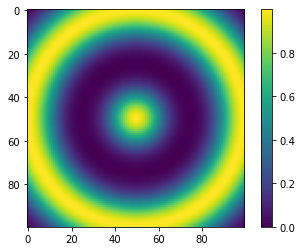

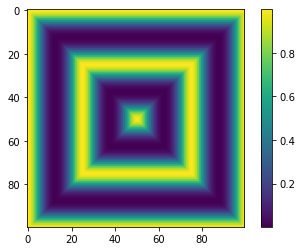

In [142]:
import matplotlib.pyplot as plt

window = radial_window_mask((100, 100), theta_shift=0, r=2*np.pi)

plt.figure()
plt.imshow(window)
plt.colorbar()

window_ = square_window_mask((100, 100), r=2*np.pi, theta_shift=0)

plt.figure()
plt.imshow(window_)
plt.colorbar()

